##  Factor Graphs and Robust Perception | Michael Kaess 
Refs: [1](https://youtu.be/JmR2YpkLNt0?t=1124)

## Factor Graph and iSAM2 Numeric Example 
Below is a **complete "small-but-real" iSAM2 example** that actually shows the advantage over batch pose-graph optimization.
I'll use **10 poses** (enough that "incremental + partial refactor" is visible), with:

* Poses $X_0,\dots,X_9$ in SE(2)
* Odometry factors for every consecutive pair
* One loop closure that connects **two nearby late poses** (not back to $X_0$), so only a **suffix** of the trajectory needs to be updated



---

## 0) State, operators, and measurement model

Each pose:

$$
X_i = (x_i, y_i, \theta_i), \quad p_i=\begin{bmatrix}x_i \\ y_i\end{bmatrix}
$$

Relative-pose prediction:

$$
h(X_i,X_j)=
\begin{bmatrix}
R(\theta_i)^T(p_j-p_i) \\
\mathrm{wrap}(\theta_j-\theta_i)
\end{bmatrix}
$$

Residual for a measurement $z_{ij}=(t_{ij},\Delta\theta_{ij})$:

$$
r_{ij}(X_i,X_j)=
\begin{bmatrix}
R(\theta_i)^T(p_j-p_i)-t_{ij} \\
\mathrm{wrap}((\theta_j-\theta_i)-\Delta\theta_{ij})
\end{bmatrix}
\in\mathbb{R}^3
$$

---

## 1) The data: 10 poses, odometry, one loop closure

### 1.1 Anchor (prior) on $X_0$

$$
z_0=(0,0,0)
$$

$$
r_0(X_0)=
\begin{bmatrix}
x_0 \\ y_0 \\ \theta_0
\end{bmatrix}
$$

### 1.2 Odometry factors ($z_{i,i+1}$) for $i=0..8$

We drive forward ~1 m each step, with tiny heading drift:

$$
z_{i,i+1}=(1.00,\ 0.00,\ 0.01)\ \ \text{for } i=0,\dots,8
$$

### 1.3 Loop closure factor (this is the "interesting" part)

Connect pose 9 to pose 6 (a **local** closure late in the trajectory):

Measured relative pose of 9 expressed in frame 6:

$$
z_{6,9}=(3.00,\ 0.10,\ 0.00)
$$

Interpretation: from $X_6$ you should see $X_9$ about 3 m ahead, slight lateral offset, almost no relative yaw.

---

## 2) Noise / information matrices (same style as before)

Odometry (moderate):

* $\sigma_{x,y}^{\text{odom}}=0.05$ m
* $\sigma_{\theta}^{\text{odom}}=0.05$ rad

$$
\Omega_{\text{odom}}=\mathrm{diag}(400,\ 400,\ 400)
$$

Loop closure (tighter):

* $\sigma_{x,y}^{\text{loop}}=0.02$ m
* $\sigma_{\theta}^{\text{loop}}=0.02$ rad

$$
\Omega_{\text{loop}}=\mathrm{diag}(2500,\ 2500,\ 2500)
$$

Strong prior:

$$
\Omega_0=\mathrm{diag}(10^6,\ 10^6,\ 10^6)
$$

---

## 3) Build initial guess by integrating odometry

Set:

$$
X_0=(0,0,0)
$$

For $i=0..8$:

$$
p_{i+1}=p_i + R(\theta_i)\begin{bmatrix}1 \\ 0\end{bmatrix}
,\quad
\theta_{i+1}=\theta_i+0.01
$$

This yields approximately a gentle arc. For the loop-closure demonstration, we only need approximate values at $X_6$ and $X_9$.

Compute headings:

$$
\theta_6=0.06,\quad \theta_9=0.09
$$

Approx positions (using $\sum \cos\theta_k$, $\sum \sin\theta_k$):

$$
x_6 \approx 5.9925,\quad y_6 \approx 0.1499
$$
$$
x_9 \approx 8.9636,\quad y_9 \approx 0.3585
$$

So:

$$
X_6 \approx (5.9925,\ 0.1499,\ 0.06)
,\quad
X_9 \approx (8.9636,\ 0.3585,\ 0.09)
$$

---


## 4) Factor graph objective (full equation)

Variables:

$$
\mathcal X=\{X_0,\dots,X_9\}
$$

Factors:

* prior ($f_0$)
* odometry factors ($f_{0,1},\dots,f_{8,9}$)
* loop closure factor ($f_{6,9}$)

Objective:

$$
\min_{\mathcal X}\
r_0(X_0)^T\Omega_0 r_0(X_0)
+
\sum_{i=0}^{8} r_{i,i+1}(X_i,X_{i+1})^T\Omega_{\text{odom}} r_{i,i+1}(X_i,X_{i+1})
+
r_{6,9}(X_6,X_9)^T\Omega_{\text{loop}} r_{6,9}(X_6,X_9)
$$

This is the same "pose graph" objective; factor-graph notation just makes the solver structure clearer.

---


After linearization at iteration $k$:

$$
\min_{\delta x}
\sum_{f \in \mathcal F}
r_f^T \Omega_f r_f
$$

Stack all residuals and Jacobians:

$$
r =
\begin{bmatrix}
r_1 \\ r_2 \\ \vdots \\ r_m
\end{bmatrix},
\quad
J =
\begin{bmatrix}
J_1 \\ J_2 \\ \vdots \\ J_m
\end{bmatrix}
$$

Global objective:

$$
\boxed{
\min_{\delta x}
(J \delta x + r)^T \Omega (J \delta x + r)
}
$$

where:

$$
\Omega =
\begin{bmatrix}
\Omega_1 & & \\
& \ddots & \\
& & \Omega_m
\end{bmatrix}
$$

This is **exactly** your pose-graph objective.

---


#### Factorizing the information matrix

Because $\Omega$ is symmetric positive definite (SPD), it has a Cholesky factorization:

$$
\Omega = L L^T
$$


In iSAM2 literature it's often written as:

$$
\boxed{\Omega = W^T W}
$$

These are the same idea; just naming the factor differently.

A consistent mapping is:

* If $\Omega = L L^T$ (lower-triangular $L$),
  then choose $W = L^T$, because:

$$
W^T W = (L^T)^T (L^T) = L L^T = \Omega
$$

So $W$ is essentially a **square-root information matrix**.




This is typically:

* Cholesky factorization
* or block-diagonal square root

For diagonal covariances (your example):

$$
\Omega_f =
\begin{bmatrix}
\sigma_x^{-2} & & \\
& \sigma_y^{-2} & \\
& & \sigma_\theta^{-2}
\end{bmatrix}
= \begin{bmatrix}
\sigma_x^{-1} & & \\
& \sigma_y^{-1} & \\
& & \sigma_\theta^{-1}
\end{bmatrix}^T
\begin{bmatrix}
\sigma_x^{-1} & & \\
& \sigma_y^{-1} & \\
& & \sigma_\theta^{-1}
\end{bmatrix}
$$

So $W$ is just **per-residual weighting**.

---






#### Substitute square-root form

Plug $\Omega = W^T W$ into the objective:

$$
(J \delta x + r)^T W^T W (J \delta x + r)
$$


Start:

$$
e^T \Omega e
$$

Substitute $\Omega = W^T W$:

$$
e^T W^T W e
$$

Now regroup using associativity (matrix multiplication is associative):

$$
e^T W^T W e = (W e)^T (W e)
$$

Why? Because:

$$
(W e)^T = e^T W^T
$$

So:

$$
e^T W^T W e = e^T W^T (W e) = (e^T W^T)(W e) = (W e)^T (W e)
$$

#### Convert to a norm

By definition, Euclidean norm squared is:

$$
|y|^2 = y^T y
$$

So with $y = W e$:

$$
(W e)^T (W e) = |W e|^2
$$

Therefore:

$$
\boxed{
(J\delta x + r)^T \Omega (J\delta x + r)
= |W(J\delta x + r)|^2
}
$$

That's the full "rearrange" step (it's not magic, it's just $y^Ty$).

---

#### Expand the inside of the norm and define $(\tilde J,\tilde r)$

Distribute $W$ (linearity):

$$
W(J\delta x + r) = WJ\delta x + Wr
$$

Now define:

$$
\boxed{\tilde J = WJ,\qquad \tilde r = Wr}
$$

Then:

$$
W(J\delta x + r)=\tilde J \delta x + \tilde r
$$

So the objective becomes:

$$
\boxed{
\min_{\delta x}\ |\tilde J \delta x + \tilde r|^2
}
$$

This is now an **ordinary (unweighted) least squares** problem because the weighting has been absorbed into the rows.

---

#### What are $J$, $r$, $\Omega$, and $W$ in a factor graph?

In a factor graph you don't usually start with one giant $\Omega$. You start per-factor:

For each factor $f$:

* residual $r_f \in \mathbb{R}^{m_f}$
* Jacobian $J_f \in \mathbb{R}^{m_f \times N}$ (only columns for the variables in that factor are nonzero)
* information $\Omega_f \in \mathbb{R}^{m_f \times m_f}$

The global stacked objects are:

$$
r =
\begin{bmatrix}
r_1 \\ \vdots \\ r_F
\end{bmatrix},
\quad
J=
\begin{bmatrix}
J_1 \\ \vdots \\ J_F
\end{bmatrix},
\quad
\Omega = \mathrm{blkdiag}(\Omega_1,\dots,\Omega_F)
$$

Then $W$ is also block diagonal:

$$
W=\mathrm{blkdiag}(W_1,\dots,W_F)
$$

where each block satisfies:

$$
\boxed{\Omega_f = W_f^T W_f}
$$

So "getting $W$" means: for each factor, compute a square-root factor $W_f$ of $\Omega_f$.

---

#### How do we get $W_f$ in practice?

You typically start from a covariance $\Sigma_f$, not $\Omega_f$.

$$
\Omega_f = \Sigma_f^{-1}
$$

Then choose:

* **Square-root covariance**: $\Sigma_f = S_f S_f^T$ (Cholesky)
* Then **square-root information** can be:

$$
W_f = S_f^{-1}
$$

Because:

$$
W_f^T W_f = (S_f^{-1})^T (S_f^{-1}) = (S_f^T)^{-1} S_f^{-1} = (S_f S_f^T)^{-1} = \Sigma_f^{-1} = \Omega_f
$$

So a clean pipeline is:

$$
\Sigma_f \xrightarrow{\text{Cholesky}} S_f
\quad\Rightarrow\quad
W_f = S_f^{-1}
$$

**Special case: diagonal covariance**

If:

$$
\Sigma_f=\mathrm{diag}(\sigma_1^2,\dots,\sigma_m^2)
$$

Then:

$$
W_f=\mathrm{diag}\left(\frac{1}{\sigma_1},\dots,\frac{1}{\sigma_m}\right)
$$

and you can see directly that $W_f^T W_f = \Omega_f$.

---

#### Tiny numeric illustration

Say a 3D residual (dx, dy, dθ) has:

$$
\Sigma=\mathrm{diag}(0.05^2,\ 0.05^2,\ 0.1^2)
$$

Then:

$$
W=\mathrm{diag}(20,\ 20,\ 10)
$$

If a residual is:

$$
r=\begin{bmatrix}0.10 \\ -0.05 \\ 0.20\end{bmatrix}
$$

Then "whitened residual" is:

$$
\tilde r=Wr=
\begin{bmatrix}
2.0 \\
-1.0 \\
2.0
\end{bmatrix}
$$

And the weighted cost equals unweighted cost on whitened residual:

$$
r^T\Omega r = |Wr|^2 = 2.0^2 + (-1.0)^2 + 2.0^2 = 9
$$

That's exactly what this transformation achieves.

---



#### Why this matters for iSAM2 specifically

iSAM2 wants:

$$
\min_{\delta x}\ |\tilde J\delta x + \tilde r|^2
$$

because it can do **QR** on $\tilde J$ incrementally. QR is naturally defined for standard least squares, and whitening makes it standard.

---


#### QR factorization (the key iSAM2 step)

Instead of forming $\tilde J^T \tilde J$, iSAM2 does:

$$
\boxed{
\tilde J = Q R
}
$$

Where:

* $Q^T Q = I$ (orthonormal)
* $R$ is upper-triangular

Dimensions:

* $\tilde J \in \mathbb{R}^{M \times N}$
* $Q \in \mathbb{R}^{M \times M}$
* $R \in \mathbb{R}^{M \times N}$

---

#### Substitute QR into the objective

Original objective:

$$
\min_{\delta x} | \tilde J \delta x + \tilde r |^2
$$

Substitute $\tilde J = Q R$:

$$
\min_{\delta x} | Q R \delta x + \tilde r |^2
$$

Insert identity $Q^T Q = I$:

$$
\min_{\delta x} | Q (R \delta x + Q^T \tilde r) |^2
$$

---

#### What does "drop orthonormal part" mean?

This is the crucial step.

Because $Q$ is orthonormal:

$$
| Q y |^2 = y^T Q^T Q y = y^T y = | y |^2
$$

So:

$$
\boxed{
| Q (R \delta x + Q^T \tilde r) |^2
= | R \delta x + Q^T \tilde r |^2
}
$$

#### Final triangular system solved by iSAM2

Because $R$ is upper-triangular:

$$
\boxed{
R \delta x = - Q^T \tilde r
}
$$

This is solved by **back-substitution**, not matrix inversion.

---

#### Why iSAM2 prefers this form (deep reason)

**Batch GN**

* Builds $H = J^T \Omega J$
* Squares condition number
* Dense fill-in
* Global solve

**iSAM2**

* Works directly with $\tilde J$
* QR is numerically stable
* Sparse
* Incremental updates
* Local refactorization

Mathematically:

$$
\text{iSAM2 never solves } H\delta x=-b
$$

but solves the **equivalent** system:

$$
R\delta x = -Q^T \tilde r
$$

---


##  The real iSAM2 trick: Bayes tree + partial refactor

iSAM2 interprets the triangular system $R$ as a **Bayes net**, and groups it into a **Bayes tree**.

When a new factor arrives (here $f_{6,9}$), iSAM2:

1. Inserts the new factor (adds a few rows to $\tilde J$)
2. Finds which variables are involved: $\{X_6,X_9\}$
3. Computes the **affected cliques** in the Bayes tree (typically a subset)
4. **Re-eliminates only that subset**, reusing the rest
5. Optionally relinearizes only variables whose $|\delta X_i|$ exceeds a threshold

---

## 5) From $R$ to a Gaussian: the Bayes net view

After QR / elimination, iSAM2 maintains a square-root factor:

$$
\tilde J \approx Q R
\quad\Rightarrow\quad
\min_{\delta x}\ |R\delta x + d|^2
\quad\text{where}\quad
d = Q^T \tilde r
$$

---


The linearized least squares corresponds to a Gaussian over increments:

$$
p(\delta x)\ \propto\ \exp\left(-\frac12|R\delta x + d|^2\right)
$$

If we expand the quadratic, this is equivalent to a Gaussian:

$$
p(\delta x) \propto \exp\left(-\frac12(\delta x-\mu)^T \Lambda (\delta x-\mu)\right)
$$

where $\Lambda$ is an information matrix. In square-root form:

$$
\Lambda = R^T R
$$

**Key point:** $R$ is upper-triangular under some variable ordering, so it encodes a *directed* factorization.

---

#### 5.1 "Conditional Gaussian" form (this is the Bayes net)

Partition variables according to an elimination ordering. For simplicity, imagine scalar variables; the block form is the same.

Suppose the ordering is $(x_1, x_2, \dots, x_n)$. Upper triangular $R$ means the $k$-th row only touches $(x_k, x_{k+1}, \dots, x_n)$. This corresponds to a conditional:

$$
p(x_k \mid x_{k+1:n})
$$

In matrix form, each conditional Gaussian can be written as:

$$
\boxed{
p(\delta x_k \mid \delta x_{\pi(k)})
\ \propto
\exp\left(
-\frac12| R_{kk} \delta x_k + R_{k\pi} \delta x_{\pi(k)} + d_k |^2
\right)
}
$$

* $R_{kk}$ is the diagonal block for variable $k$
* $\pi(k)$ are the "parents" of $k$ in the Bayes net (the later variables coupled to it)

Then the whole distribution factorizes:

$$
\boxed{
p(\delta x) = \prod_{k=1}^{n} p(\delta x_k \mid \delta x_{\pi(k)})
}
$$

That directed product is the **Bayes net**.

---

#### 6) From Bayes net to Bayes tree (cliques)

A Bayes tree groups multiple conditionals into cliques to represent sparsity and enable local updates.

A clique $C$ is split into:

* **frontal variables** $(F_C)$: variables eliminated at that clique
* **separator variables** $(S_C)$: variables shared with the parent clique (the "parents")

Each clique stores one conditional density:

$$
\boxed{
p(\delta x_{F_C}\mid \delta x_{S_C})
\ \propto
\exp\left(
-\frac12| R_C \delta x_{F_C} + S_C \delta x_{S_C} + d_C |^2
\right)
}
$$

And the whole joint factorizes as product over cliques:

$$
\boxed{
p(\delta x)=\prod_{C\in\mathcal{T}} p(\delta x_{F_C}\mid \delta x_{S_C})
}
$$

where $\mathcal{T}$ is the Bayes tree.

This is just the same Gaussian encoded in a different (tree-structured) way.

---

## 7) "Insert a new factor" as adding rows to $\tilde J$

A new measurement factor $f$ (e.g. loop closure $f_{6,9}$) contributes a residual $r_f$ and Jacobian $J_f$ over only the involved variables:

$$
r_f(\delta x_f)\approx r_f^k + J_f \delta x_f
$$

Whiten it:

$$
\tilde r_f = W_f r_f^k,\quad \tilde J_f = W_f J_f
$$

Adding the factor means appending rows:

$$
\boxed{
\tilde J^+ =
\begin{bmatrix}
\tilde J \\
\tilde J_f
\end{bmatrix},
\quad
\tilde r^+ =
\begin{bmatrix}
\tilde r \\
\tilde r_f
\end{bmatrix}
}
$$

Batch would now recompute QR of $\tilde J^+$ globally.

iSAM2 does not.

---

## 8) Affected variables, affected cliques (formal)

Let the new factor touches variables:

$$
V_f = \{X_6, X_9\}
$$

In the Bayes tree, each variable belongs to exactly one clique as a frontal variable.

Define:

* $\mathrm{clique}(X_i)$: the clique where $X_i$ is frontal.

The initial set of cliques "hit" by the factor is:

$$
\mathcal{C}_0 = \{\mathrm{clique}(X)\ :\ X \in V_f\}
$$

Now define the **affected region** as those cliques plus all their ancestors up to the root (because separators connect upward):

$$
\boxed{
\mathcal{C}_{\text{aff}} = \mathrm{Ancestors}(\mathcal{C}_0)\ \cup\ \mathcal{C}_0
}
$$

Everything outside $\mathcal{C}_{\text{aff}}$ can be reused unchanged.

That is the precise meaning of "affected cliques".

---

## 9) Partial refactor = re-eliminate only the affected region

Each clique represents a conditional of the form:

$$
p(\delta x_{F_C}\mid \delta x_{S_C})
$$

To update only locally, iSAM2:

#### 9.1 Removes the affected subtree and converts it back into factors

Let $\mathcal{C}_{\text{aff}}$ form a connected subtree. iSAM2 removes those cliques and collects all factors that belong to them (including the new factor). Conceptually, it reconstructs a local factor graph:

$$
\mathcal{F}_{\text{local}} =
\left(\bigcup_{C\in\mathcal{C}_{\text{aff}}} \mathcal{F}(C)\right)\ \cup\ \{f\}
$$

where $\mathcal{F}(C)$ are the original factors absorbed into clique $C$.

#### 9.2 Re-eliminates only the local part

Elimination means performing QR / Gaussian elimination on only the local whitened Jacobian:

$$
\tilde J_{\text{local}} = W_{\text{local}}J_{\text{local}}
$$

Compute local factorization:

$$
\boxed{
\tilde J_{\text{local}} = Q_{\text{local}} R_{\text{local}}
}
$$

This produces updated conditionals (cliques) for that region, which are re-attached to the unchanged remainder of the tree via the separators.

**This is the partial refactor.**
The unchanged cliques retain their existing $R$-blocks and conditionals.

---

## 10) Partial relinearization threshold (equation)

Each nonlinear factor is linearized around the current estimate. iSAM2 does not relinearize every time. It uses a per-variable increment test.

Let the latest increment estimate be $\Delta X_i$ (in tangent space), e.g.:

$$
\Delta X_i =
\begin{bmatrix}
\Delta x_i \\
\Delta y_i \\
\Delta\theta_i
\end{bmatrix}
$$

A common policy is:

$$
\boxed{
|\Delta X_i| > \epsilon\ \Rightarrow\ \text{mark } X_i \text{ for relinearization}
}
$$

Sometimes angle has its own scaling; a weighted norm is used:

$$
\boxed{
|\Delta X_i|_{D}^2 = \Delta X_i^T D \Delta X_i > \epsilon^2
}
$$

where $D$ balances meters vs radians.

Only factors involving "marked" variables are relinearized:

$$
\boxed{
X_i \text{ marked} \Rightarrow \forall f \text{ s.t. } X_i \in V_f,\ \text{recompute } r_f^k,\ J_f
}
$$

This is a big runtime win.

---

## 11) Why this is better than batch pose-graph GN (the exact "better" part)

Batch GN does:

* linearize many/all factors
* build global $\tilde J$
* compute global QR/Cholesky again

iSAM2 does:

* insert new factor rows $\tilde J_f$
* find $\mathcal{C}_{\text{aff}}$ (a subset)
* rebuild only $\tilde J_{\text{local}}$
* do QR only on that local part
* reuse the rest of the Bayes tree unchanged
* relinearize only when $|\Delta X_i|$ is large

So the "better" part is precisely:

$$
\boxed{
\text{Refactorization cost} \propto |\mathcal{C}_{\text{aff}}|
\quad\text{instead of}\quad
|\mathcal{T}|
}
$$

and similarly for relinearization.

---



## 1) Build initial guess by integrating odometry (done, but I'll restate the result)

Odometry measurement for each step:

$$
z_{i,i+1} = (\Delta x,\Delta y,\Delta\theta) = (1.0,\ 0.0,\ 0.01)
$$

Propagation model:

$$
p_{i+1}=p_i + R(\theta_i)\begin{bmatrix}1 \\ 0\end{bmatrix},\quad
\theta_{i+1}=\mathrm{wrap}(\theta_i+0.01)
$$

with

$$
R(\theta)=
\begin{bmatrix}\cos\theta&-\sin\theta \\ \sin\theta&\cos\theta\end{bmatrix}
$$

This gives an initial guess (I'll list the ones we'll use later):

$$
X_6 \approx (5.99725041,\ 0.14996250,\ 0.06)
$$
$$
X_9 \approx (8.98980365,\ 0.35978405,\ 0.09)
$$

---

## 2) Measurements and noise (information matrices)

### Prior on $X_0$

$$
z_0=(0,0,0),\quad r_0(X_0)=\begin{bmatrix}x_0 \\ y_0 \\ \theta_0\end{bmatrix}
$$
$$
\Omega_0=\mathrm{diag}(10^6,\ 10^6,\ 10^6)
$$

### Odometry factors

$$
\Omega_{\text{odom}}=\mathrm{diag}(400,\ 400,\ 400)
$$

### Loop closure factor $(6\to 9)$

Measurement:

$$
z_{6,9} = (3.00,\ 0.10,\ 0.00)
$$
$$
\Omega_{\text{loop}}=\mathrm{diag}(2500,\ 2500,\ 2500)
$$

---

## 3) Factor graph (pose graph is this special case)

Predicted relative pose:

$$
h(X_i,X_j)=
\begin{bmatrix}
R(\theta_i)^T(p_j-p_i) \\
\mathrm{wrap}(\theta_j-\theta_i)
\end{bmatrix}
$$

Residual (prediction minus measurement):

$$
r_{ij}(X_i,X_j)=
\begin{bmatrix}
R(\theta_i)^T(p_j-p_i)-t_{ij} \\
\mathrm{wrap}((\theta_j-\theta_i)-\Delta\theta_{ij})
\end{bmatrix}
$$

Objective:

$$
\min_{\mathcal X}\
r_0(X_0)^T\Omega_0 r_0(X_0)
+
\sum_{i=0}^{8} r_{i,i+1}(X_i,X_{i+1})^T\Omega_{\text{odom}} r_{i,i+1}(X_i,X_{i+1})
+
r_{6,9}(X_6,X_9)^T\Omega_{\text{loop}} r_{6,9}(X_6,X_9)
$$

---

## 4) Compute the loop-closure residual at the initial guess (numeric)

Prediction:

$$
\hat t_{6,9}=R(\theta_6)^T(p_9-p_6),\quad \hat\theta_{6,9}=\mathrm{wrap}(\theta_9-\theta_6)
$$

At the initial guess, this evaluates to approximately:

$$
\hat z_{6,9}\approx(2.99975001,\ 0.02999850,\ 0.03)
$$

So residual:

$$
r_{6,9} = \hat z_{6,9}-z_{6,9}
\approx
\begin{bmatrix}
-0.00024999 \\
-0.07000150 \\
0.03
\end{bmatrix}
$$

Interpretation: the trajectory is ~7 cm "too low" in the loop closure's local $y$, and heading differs by ~0.03 rad.

---

## 5) Linearize (Jacobian blocks) — used by both batch GN and iSAM2

For a binary factor $(i,j)$, linearize around current estimate:

$$
r_{ij}(X_i\oplus \delta X_i,\ X_j\oplus \delta X_j)
\approx
r_{ij}^k + A_{ij}\delta X_i + B_{ij}\delta X_j
$$

Jacobians:

$$
B_{ij}=
\begin{bmatrix}
R(\theta_i)^T & 0 \\
0\ 0 & 1
\end{bmatrix}
$$

$$
A_{ij}=
\begin{bmatrix}
R(\theta_i)^T & d_{ij} \\
0\ 0 & -1
\end{bmatrix}
$$

where

$$
d_{ij}=
\left(\frac{\partial R(\theta_i)^T}{\partial \theta_i}\right)(p_j-p_i),
\quad
\frac{\partial R(\theta)^T}{\partial \theta}=
\begin{bmatrix}
-\sin\theta & \cos\theta \\
-\cos\theta & -\sin\theta
\end{bmatrix}
$$

---

## 6) Batch pose-graph solve (one Gauss-Newton iteration, numeric result)

Stack increments:

$$
\delta x=
\begin{bmatrix}
\delta X_0 \\ \delta X_1 \\ \vdots \\ \delta X_9
\end{bmatrix}
\in\mathbb{R}^{30}
$$

Square-root / whitened form:

$$
\min_{\delta x}\ |\tilde J\delta x + \tilde r|^2
\quad\text{with}\quad
\tilde J=WJ,\ \tilde r=Wr
$$

Batch "normal equations" form (what many pose-graph solvers do):

$$
H\delta x = -b,\quad H=J^T\Omega J,\quad b=J^T\Omega r
$$

### What happens numerically here

Because the initial guess was integrated from odometry, the odometry residuals are ~0, so the only "force" is from the loop closure. Solving the full system gives (dominant nonzero updates):

$$
\delta X_7 \approx (-0.00099232,\ 0.01851563,\ 0.00998328)
$$
$$
\delta X_8 \approx (-0.00268291,\ 0.04699009,\ 0.00142687)
$$
$$
\delta X_9 \approx (-0.00378926,\ 0.06692802,\ -0.02566526)
$$

and all earlier $\delta X_0..\delta X_6$ are ~0 (tiny numerical noise), because the prior + odometry chain makes it cheaper to "bend" the last few poses to satisfy a late local loop closure.

Update rule (simple additive):

$$
X_i^{\text{new}} = X_i \oplus \delta X_i \approx (x_i+\delta x_i,\ y_i+\delta y_i,\ \mathrm{wrap}(\theta_i+\delta\theta_i))
$$

So updated poses:

$$
X_7^{\text{new}} \approx (6.99445862,\ 0.22844214,\ 0.07998328)
$$
$$
X_8^{\text{new}} \approx (7.99031904,\ 0.32685945,\ 0.08142687)
$$
$$
X_9^{\text{new}} \approx (8.98601440,\ 0.42671208,\ 0.06433474)
$$

### Check: loop closure residual after this one update

New predicted relative pose:

$$
\hat z_{6,9}^{\text{new}}\approx(2.99998084,\ 0.09703331,\ 0.00433474)
$$

Residual:

$$
r_{6,9}^{\text{new}}=\hat z_{6,9}^{\text{new}}-z_{6,9}
\approx
\begin{bmatrix}
-1.9157\times 10^{-5} \\
-2.9667\times 10^{-3} \\
4.3347\times 10^{-3}
\end{bmatrix}
$$

So the 7 cm lateral error dropped to about 3 mm in one GN step.

That completes the batch pose-graph solution step.

---

## 7) Now: the same example solved incrementally with iSAM2

iSAM2 solves the **same linearized least squares**, but updates the factorization incrementally.

### 7.1 What iSAM2 maintains (Bayes tree form)

From the whitened system:

$$
\min_{\delta x}\ |\tilde J\delta x + \tilde r|^2
$$

iSAM2 keeps an incremental QR / elimination:

$$
\tilde J = QR
\quad\Rightarrow\quad
\min_{\delta x}\ |R\delta x + d|^2,\ \ d=Q^T\tilde r
$$

The triangular $R$ corresponds to a Gaussian:

$$
p(\delta x)\propto \exp\left(-\frac12|R\delta x + d|^2\right)
$$

and factors into conditionals (Bayes net), which are grouped into cliques (Bayes tree):

$$
p(\delta x)=\prod_{C\in\mathcal T} p(\delta x_{F_C}\mid \delta x_{S_C})
$$

Each clique conditional can be written in square-root form as:

$$
p(\delta x_{F_C}\mid \delta x_{S_C})
\propto
\exp\left(
-\frac12| R_C\delta x_{F_C} + S_C\delta x_{S_C} + d_C|^2
\right)
$$

### 7.2 Timeline: how iSAM2 would process our 10-pose stream

#### Step A: add prior + odometry factors sequentially

For each new odometry factor $f_{i,i+1}$, iSAM2:

* linearizes it (compute $r_{i,i+1}$, $A_{i,i+1},B_{i,i+1}$)
* whitens it ($\tilde J_f=W_f J_f$, $\tilde r_f=W_f r_f$)
* inserts it (adds rows to $\tilde J$)
* updates the Bayes tree incrementally (local QR updates)

Because odometry residuals are ~0 at the integrated guess, updates are tiny.

#### Step B: loop closure arrives ($f_{6,9}$)

This is the key event.

New factor:

$$
\tilde J^+ =
\begin{bmatrix}
\tilde J \\
\tilde J_{6,9}
\end{bmatrix},
\quad
\tilde r^+ =
\begin{bmatrix}
\tilde r \\
\tilde r_{6,9}
\end{bmatrix}
$$

Touched variables:

$$
V_f=\{X_6,X_9\}
$$

Affected cliques are "where these variables live" plus ancestors:

$$
\mathcal C_{\text{aff}}=
\mathrm{Ancestors}\Big(\{\mathrm{clique}(X_6),\mathrm{clique}(X_9)\}\Big)
\cup
\{\mathrm{clique}(X_6),\mathrm{clique}(X_9)\}
$$

Then iSAM2 **removes only that subtree**, rebuilds a **local** system, and re-eliminates **only locally**:

$$
\tilde J_{\text{local}} = Q_{\text{local}} R_{\text{local}}
$$

Everything outside $\mathcal C_{\text{aff}}$ is reused unchanged.

### What that means in this specific numeric example

The batch GN solution above showed that only:

$$
X_7,\ X_8,\ X_9
$$

moved noticeably to satisfy the loop closure. That is exactly the kind of situation iSAM2 exploits: it can re-factor only the cliques involving the late portion (often roughly the suffix around poses 6-9, depending on ordering), not the whole history.

---

## 8) Pose graph (batch) vs iSAM2: what's actually different and better

### Same math (objective)

Both minimize:

$$
\sum_f r_f^T\Omega_f r_f
$$

### Different solve strategy

#### Batch pose graph approach

Typically (conceptually):

1. Linearize many/all factors → build global $J,r$
2. Build or factor global system (e.g. $H=J^T\Omega J$)
3. Solve for all $\delta x$ (full solve)

Cost grows with total graph size.

#### iSAM2 approach (better for streaming SLAM)

1. Maintain square-root factorization (Bayes tree) of the linearized system
2. When a new factor arrives, identify affected cliques
3. Re-eliminate only affected part (partial refactor)
4. Optionally relinearize only variables with large increments:

$$
|\Delta X_i|>\epsilon \ \Rightarrow\ \text{relinearize variables/factors involving }X_i
$$

**Why better:** for long trajectories, $|\mathcal C_{\text{aff}}|\ll |\mathcal T|$ most of the time, so updates are much cheaper than refactoring the whole problem.

---



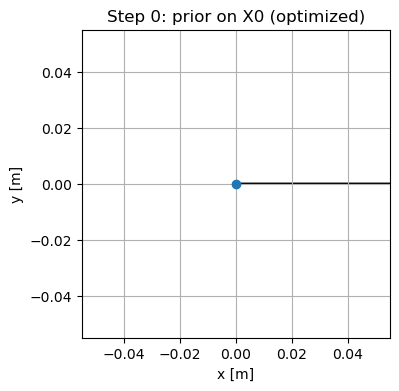

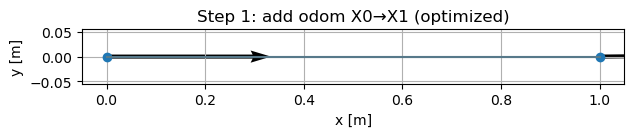

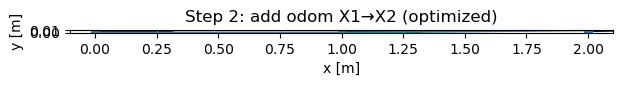

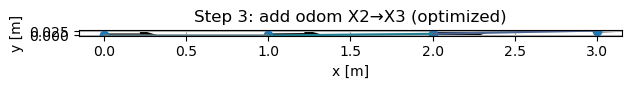

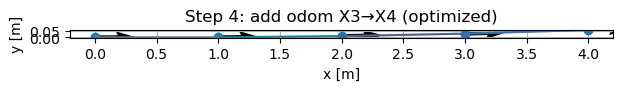

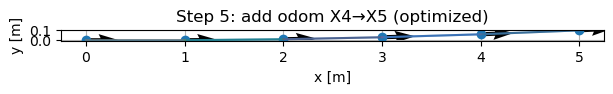

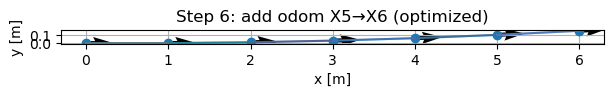

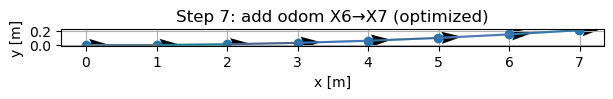

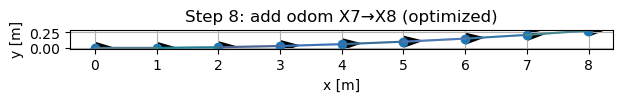

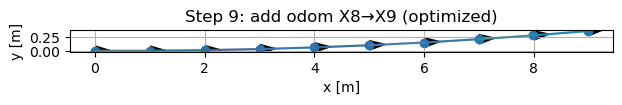

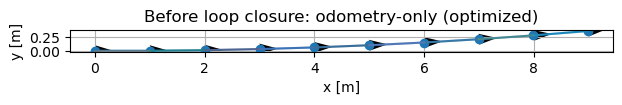

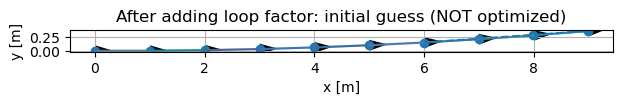

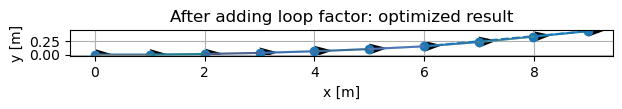

Final optimized poses:
X0: x=-0.0000, y= 0.0000, theta= 0.0000 rad
X1: x= 1.0000, y= 0.0000, theta= 0.0100 rad
X2: x= 2.0000, y= 0.0100, theta= 0.0200 rad
X3: x= 2.9998, y= 0.0300, theta= 0.0300 rad
X4: x= 3.9993, y= 0.0600, theta= 0.0400 rad
X5: x= 4.9985, y= 0.1000, theta= 0.0500 rad
X6: x= 5.9973, y= 0.1500, theta= 0.0600 rad
X7: x= 6.9948, y= 0.2285, theta= 0.0800 rad
X8: x= 7.9906, y= 0.3269, theta= 0.0814 rad
X9: x= 8.9860, y= 0.4267, theta= 0.0643 rad


In [3]:
import numpy as np
import matplotlib.pyplot as plt

import gtsam
from gtsam import symbol

# -----------------------------
# Helpers
# -----------------------------
def sigmas_from_information(diag_info):
    # info = 1/sigma^2  =>  sigma = 1/sqrt(info)
    diag_info = np.asarray(diag_info, dtype=float)
    return 1.0 / np.sqrt(diag_info)

def optimize(graph: gtsam.NonlinearFactorGraph, initial: gtsam.Values) -> gtsam.Values:
    params = gtsam.LevenbergMarquardtParams()
    params.setVerbosityLM("SILENT")
    return gtsam.LevenbergMarquardtOptimizer(graph, initial, params).optimize()

def values_sorted_keys(values: gtsam.Values):
    return sorted([k for k in values.keys()])

def values_to_xytheta(values: gtsam.Values, keys):
    xs, ys, th = [], [], []
    for k in keys:
        p = values.atPose2(k)
        xs.append(p.x())
        ys.append(p.y())
        th.append(p.theta())
    return np.array(xs), np.array(ys), np.array(th)

def plot_step(values: gtsam.Values, odom_edges, loop_edges, title):
    keys = values_sorted_keys(values)
    xs, ys, th = values_to_xytheta(values, keys)

    fig, ax = plt.subplots(figsize=(7, 4))

    # trajectory polyline through sorted keys
    ax.plot(xs, ys, marker="o", linestyle="-")

    # orientation arrows (unit vectors)
    ax.quiver(xs, ys, np.cos(th), np.sin(th), angles="xy", scale_units="xy", scale=3)

    # draw factor edges
    def draw_edges(edges, style="-", alpha=0.6):
        for (a, b) in edges:
            pa = values.atPose2(a)
            pb = values.atPose2(b)
            ax.plot([pa.x(), pb.x()], [pa.y(), pb.y()], style, alpha=alpha)

    draw_edges(odom_edges, style="-", alpha=0.25)   # odom edges
    draw_edges(loop_edges, style="--", alpha=0.95)  # loop edges

    ax.set_aspect("equal", adjustable="box")
    ax.grid(True)
    ax.set_title(title)
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    plt.show()

# -----------------------------
# Problem data (your numbers)
# -----------------------------
N = 10
X = lambda i: symbol("x", i)

# Information matrices (diagonal)
Omega_odom = [400, 400, 400]      # -> sigmas [0.05, 0.05, 0.05]
Omega_loop = [2500, 2500, 2500]   # -> sigmas [0.02, 0.02, 0.02]
Omega_0    = [1e6, 1e6, 1e6]      # -> sigmas [0.001, 0.001, 0.001]

sig_odom = sigmas_from_information(Omega_odom)
sig_loop = sigmas_from_information(Omega_loop)
sig_0    = sigmas_from_information(Omega_0)

noise_odom = gtsam.noiseModel.Diagonal.Sigmas(sig_odom)
noise_loop = gtsam.noiseModel.Diagonal.Sigmas(sig_loop)
noise_0    = gtsam.noiseModel.Diagonal.Sigmas(sig_0)

# Measurements as Pose2 (dx, dy, dtheta)
z0 = gtsam.Pose2(0.0, 0.0, 0.0)
z_odom = gtsam.Pose2(1.0, 0.0, 0.01)
z_loop_6_9 = gtsam.Pose2(3.0, 0.10, 0.0)

# -----------------------------
# Incremental build + visualize
# -----------------------------
graph = gtsam.NonlinearFactorGraph()
initial = gtsam.Values()

odom_edges = []
loop_edges = []

# Step 0: prior on X0
graph.add(gtsam.PriorFactorPose2(X(0), z0, noise_0))
initial.insert(X(0), z0)

result = optimize(graph, initial)
plot_step(result, odom_edges, loop_edges, "Step 0: prior on X0 (optimized)")

# Steps 1..9: add odometry one by one
for i in range(N - 1):
    graph.add(gtsam.BetweenFactorPose2(X(i), X(i + 1), z_odom, noise_odom))
    odom_edges.append((X(i), X(i + 1)))

    # chained initial guess
    prev = initial.atPose2(X(i))
    initial.insert(X(i + 1), prev.compose(z_odom))

    result = optimize(graph, initial)
    plot_step(result, odom_edges, loop_edges, f"Step {i+1}: add odom X{i}→X{i+1} (optimized)")

# Before loop closure
result_before = optimize(graph, initial)
plot_step(result_before, odom_edges, loop_edges, "Before loop closure: odometry-only (optimized)")

# Add loop closure 6 -> 9
graph.add(gtsam.BetweenFactorPose2(X(6), X(9), z_loop_6_9, noise_loop))
loop_edges.append((X(6), X(9)))

# Show initial guess with loop edge (not re-optimized yet)
plot_step(initial, odom_edges, loop_edges, "After adding loop factor: initial guess (NOT optimized)")

# Re-optimize with loop closure
result_after = optimize(graph, initial)
plot_step(result_after, odom_edges, loop_edges, "After adding loop factor: optimized result")

# Print final poses
print("Final optimized poses:")
for i in range(N):
    p = result_after.atPose2(X(i))
    print(f"X{i}: x={p.x(): .4f}, y={p.y(): .4f}, theta={p.theta(): .4f} rad")


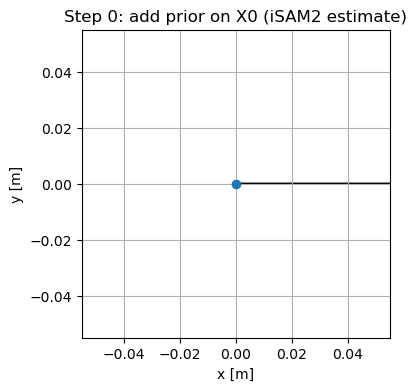

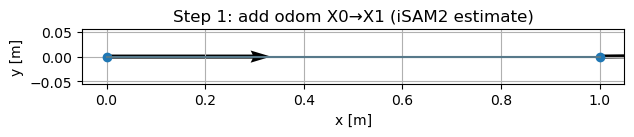

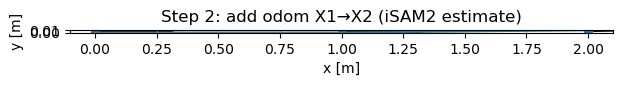

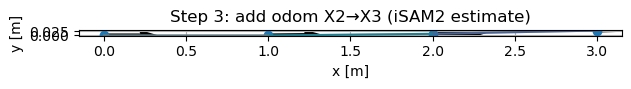

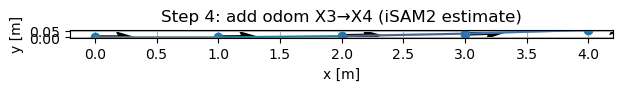

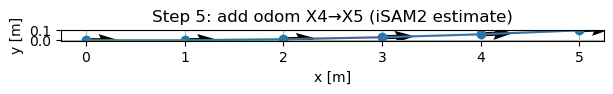

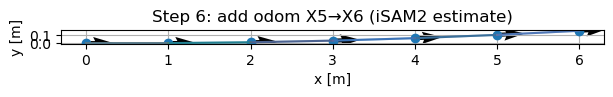

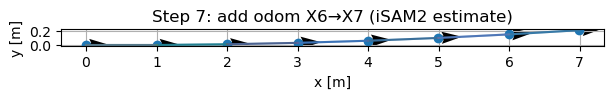

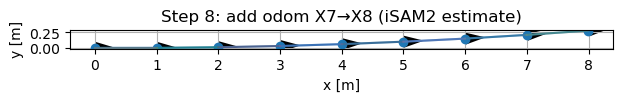

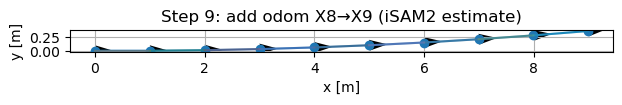

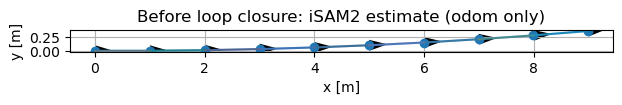

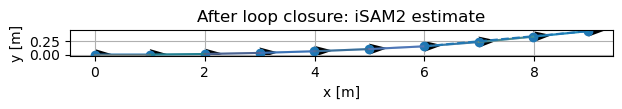

Final iSAM2 poses:
X0: x= 0.0000, y= 0.0000, theta= 0.0000 rad
X1: x= 1.0000, y= 0.0000, theta= 0.0100 rad
X2: x= 2.0000, y= 0.0100, theta= 0.0200 rad
X3: x= 2.9998, y= 0.0300, theta= 0.0300 rad
X4: x= 3.9993, y= 0.0600, theta= 0.0400 rad
X5: x= 4.9985, y= 0.1000, theta= 0.0500 rad
X6: x= 5.9973, y= 0.1500, theta= 0.0600 rad
X7: x= 6.9938, y= 0.2284, theta= 0.0800 rad
X8: x= 7.9890, y= 0.3268, theta= 0.0814 rad
X9: x= 8.9840, y= 0.4266, theta= 0.0643 rad


In [5]:
import numpy as np
import matplotlib.pyplot as plt

import gtsam
from gtsam import symbol

# -----------------------------
# Helpers
# -----------------------------


def sigmas_from_information(diag_info):
    diag_info = np.asarray(diag_info, dtype=float)
    return 1.0 / np.sqrt(diag_info)


def values_sorted_keys(values: gtsam.Values):
    return sorted([k for k in values.keys()])


def values_to_xytheta(values: gtsam.Values, keys):
    xs, ys, th = [], [], []
    for k in keys:
        p = values.atPose2(k)
        xs.append(p.x())
        ys.append(p.y())
        th.append(p.theta())
    return np.array(xs), np.array(ys), np.array(th)


def plot_step(values: gtsam.Values, odom_edges, loop_edges, title):
    keys = values_sorted_keys(values)
    xs, ys, th = values_to_xytheta(values, keys)

    fig, ax = plt.subplots(figsize=(7, 4))

    # trajectory line through sorted keys
    ax.plot(xs, ys, marker="o", linestyle="-")

    # orientation arrows
    ax.quiver(xs, ys, np.cos(th), np.sin(th),
              angles="xy", scale_units="xy", scale=3)

    # draw factor edges
    def draw_edges(edges, style="-", alpha=0.6):
        for (a, b) in edges:
            pa = values.atPose2(a)
            pb = values.atPose2(b)
            ax.plot([pa.x(), pb.x()], [pa.y(), pb.y()], style, alpha=alpha)

    draw_edges(odom_edges, style="-", alpha=0.25)
    draw_edges(loop_edges, style="--", alpha=0.95)

    ax.set_aspect("equal", adjustable="box")
    ax.grid(True)
    ax.set_title(title)
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    plt.show()


# -----------------------------
# Problem data (your numbers)
# -----------------------------
N = 10
def X(i): return symbol("x", i)


# Information matrices (diagonal)
Omega_odom = [400, 400, 400]      # sigmas -> [0.05, 0.05, 0.05]
Omega_loop = [2500, 2500, 2500]   # sigmas -> [0.02, 0.02, 0.02]
Omega_0 = [1e6, 1e6, 1e6]      # sigmas -> [0.001, 0.001, 0.001]

sig_odom = sigmas_from_information(Omega_odom)
sig_loop = sigmas_from_information(Omega_loop)
sig_0 = sigmas_from_information(Omega_0)

noise_odom = gtsam.noiseModel.Diagonal.Sigmas(sig_odom)
noise_loop = gtsam.noiseModel.Diagonal.Sigmas(sig_loop)
noise_0 = gtsam.noiseModel.Diagonal.Sigmas(sig_0)

# Measurements as Pose2 (dx, dy, dtheta)
z0 = gtsam.Pose2(0.0, 0.0, 0.0)
z_odom = gtsam.Pose2(1.0, 0.0, 0.01)
z_loop_6_9 = gtsam.Pose2(3.0, 0.10, 0.0)

# -----------------------------
# iSAM2 setup
# -----------------------------
isam_params = gtsam.ISAM2Params()
# A couple of sensible defaults for this toy problem:
isam_params.setRelinearizeThreshold(0.01)
isam_params.relinearizeSkip = 1
isam = gtsam.ISAM2(isam_params)

odom_edges = []
loop_edges = []

# Keep an "initial guesses" container you can extend incrementally
initial = gtsam.Values()


def isam_update_and_plot(new_factors: gtsam.NonlinearFactorGraph,
                         new_values: gtsam.Values,
                         title: str):
    # Update iSAM2 with the newly added factors/values
    isam.update(new_factors, new_values)
    # You can call update() again to force additional relinearization if desired:
    # isam.update()

    # Current best estimate
    estimate = isam.calculateEstimate()
    plot_step(estimate, odom_edges, loop_edges, title)

    return estimate


# -----------------------------
# Step 0: prior + X0
# -----------------------------
new_factors = gtsam.NonlinearFactorGraph()
new_values = gtsam.Values()

new_factors.add(gtsam.PriorFactorPose2(X(0), z0, noise_0))
new_values.insert(X(0), z0)
initial.insert(X(0), z0)

est = isam_update_and_plot(new_factors, new_values,
                           "Step 0: add prior on X0 (iSAM2 estimate)")

# -----------------------------
# Steps 1..9: add odometry factors one by one
# -----------------------------
for i in range(N - 1):
    new_factors = gtsam.NonlinearFactorGraph()
    new_values = gtsam.Values()

    # add odom factor
    new_factors.add(gtsam.BetweenFactorPose2(
        X(i), X(i + 1), z_odom, noise_odom))
    odom_edges.append((X(i), X(i + 1)))

    # initial guess for new node by chaining from current estimate (more stable than chaining initial)
    est_i = isam.calculateEstimate().atPose2(X(i))
    guess_next = est_i.compose(z_odom)

    new_values.insert(X(i + 1), guess_next)
    initial.insert(X(i + 1), guess_next)

    est = isam_update_and_plot(
        new_factors,
        new_values,
        f"Step {i+1}: add odom X{i}→X{i+1} (iSAM2 estimate)"
    )

# Before loop closure: plot current estimate
plot_step(isam.calculateEstimate(), odom_edges, loop_edges,
          "Before loop closure: iSAM2 estimate (odom only)")

# -----------------------------
# Add loop closure 6 -> 9
# -----------------------------
new_factors = gtsam.NonlinearFactorGraph()
new_values = gtsam.Values()  # no new nodes, so empty is fine

new_factors.add(gtsam.BetweenFactorPose2(X(6), X(9), z_loop_6_9, noise_loop))
loop_edges.append((X(6), X(9)))

est = isam_update_and_plot(new_factors, new_values,
                           "After loop closure: iSAM2 estimate")

# -----------------------------
# Print final poses
# -----------------------------
final_est = isam.calculateEstimate()
print("Final iSAM2 poses:")
for i in range(N):
    p = final_est.atPose2(X(i))
    print(f"X{i}: x={p.x(): .4f}, y={p.y(): .4f}, theta={p.theta(): .4f} rad")



Refs: [1](https://www.youtube.com/watch?v=uuiaqGLFYa4&t=145s), [2](https://gtsam.org/), [3](https://github.com/borglab/gtsam), [4](https://openslam-org.github.io/iSAM), [5](https://github.com/JeffLIrion/python-graphslam), [6](https://python-graphslam.readthedocs.io/en/stable/), [7](https://www.youtube.com/watch?v=zOr9HreMthY), [8](https://github.com/gisbi-kim/modern-slam-tutorial-python/b)
[9](https://github.com/gisbi-kim/modern-slam-tutorial-python), [10](https://www.youtube.com/watch?v=zOr9HreMthY)
